### De reținut

Acest notebook necesită instalarea pachetului torchmetrics: `conda install -c conda-forge torchmetrics`

Spre deosebire de tensorflow, pytorch așteaptă input de forma channel first, C x H x W.

Clasa CrossEntropyLoss include funcția Softmax, ea nu mai trebuie aplicată ca și ultimul strat pentru o rețea. De asemenea, în timpul validării/testării, funcția Softmax va trebui aplicată manual pentru a converti output-ul raw al rețelei, adică *logits* în probabilități.

`torch.set_grad_enabled` activează/dezactivează calcularea gradienților, ceea este util pentru a schimba modul de la antrenare la validare/testare. Se folosește concomitent cu `network.train()` și `network.eval()`

In [337]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib as pt
import random
import yaml
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchmetrics 

from tqdm import tqdm
from UNetModel import UNet


print(f"pyTorch version {torch.__version__}")
print(f"torchvision version {torchvision.__version__}")
print(f"torchmetrics version {torchmetrics.__version__}")
print(f"CUDA available {torch.cuda.is_available()}")

pyTorch version 1.10.1
torchvision version 0.11.2
torchmetrics version 0.7.0
CUDA available True


In [338]:
config = None
with open('config.yaml') as f: # reads .yml/.yaml files
    config = yaml.safe_load(f)

## Creare dataset

In [339]:
def create_dataset_csv(images_dir, right_masks_dir, left_masks_dir, csv_path):
    """Generare csv cu caile catre imaginile de input si mastile de segmentare

    Args:
        images_dir (str or pathlib.Path): calea catre directorul cu imagini de input
        right_masks_dir (str or pathlib.Path): calea catre directorul cu masti de segmentare pt plamanul drept
        left_masks_dir (str or pathlib.Path): calea catre directorul cu masti de segmentare pt plamanul stang
        csv_path (str or pathlib.Path): calea si numele fisierul csv care va fi salvat

    Returns:
        pandas.DataFrame: contine caile catre fiecare imagine de input sau masca de segmentare
    """

    # se citesc toate caile catre imagini si masti de segmentare
    # este important sa fie in aceeasi ordine
    images = sorted(list(pt.Path(images_dir).rglob("*.png")))
    right_masks = sorted(list(pt.Path(right_masks_dir).rglob("*.png")))
    left_masks = sorted(list(pt.Path(left_masks_dir).rglob("*.png")))

    # se verifica daca nu exista masti lipsa pentru unul dintre plamani
    assert len(right_masks) == len(left_masks), \
         f"nr. of right lung masks {len(right_masks)} != {len(left_masks)} nr. of left lung masks"
    
    # se verifica daca nu exista imagini sau masti lipsa
    assert len(images) == len(left_masks), \
         f"nr. of image{len(images)} != {len(left_masks)} nr. of masks"

    # se creaza un dictionar de liste, pe baza caruia se creaza obiectul de tip pandas.DataFrame
    dataset_data = {"image_path": images, "right_lung_mask_path": right_masks, "left_lung_mask_path": left_masks}

    dataset_df = pd.DataFrame(data=dataset_data)
    dataset_df.to_csv(csv_path, index=False)
    print(f"Saved dataset csv {csv_path}")

    return dataset_df

def split_dataset(dataset_df, split_per, seed=1):
    """Impartirea setului de date in antrenare, validare si testare in mod aleatoriu

    Args:
        dataset_df (pandas.DataFrame): contine caile catre imaginile de input si mastile de segmentare
        split_per (dict): un dictionare de forma {"train": float, "valid": float, "test": float} ce descrie
            procentajele pentru fiecare subset
        seed (int, optional): valoarea seed pentru reproducerea impartirii setului de date. Defaults to 1.
    """
    # se amesteca aleatoriu indecsii DataFrame-ului
    # indexul este un numar (de cele mai multe ori) asociat fiecarui rand
    indices = dataset_df.index.to_numpy() 
    total = len(indices)
    random.seed(seed)
    random.shuffle(indices)

    # se impart indecsii in functie de procentele primite ca input
    train_idx = int(total * split_per["train"])
    valid_idx = train_idx + int(total * split_per["valid"])
    test_idx = train_idx + valid_idx + int(total * split_per["test"])

    train_indices = indices[:train_idx]
    valid_indices = indices[train_idx:valid_idx]
    test_indices = indices[valid_idx:test_idx]

#     print(len(train_indices), len(valid_indices), len(test_indices))

    # se adauga o noua coloana la DataFrame care specifica in ce subset face parte o imagine si mastile de segmentare asociate
    dataset_df['subset'] = ""
    dataset_df.loc[train_indices, "subset"] = "train"
    dataset_df.loc[valid_indices, "subset"] = "valid"
    dataset_df.loc[test_indices, "subset"] = "test"

    return dataset_df

In [340]:
dataset_df = create_dataset_csv(config["data"]["images_dir"], 
                                config["data"]["right_masks_dir"],
                                config["data"]["left_masks_dir"],
                                config["data"]["data_csv"])

Saved dataset csv dataset_seg.csv


In [341]:
dataset_df = split_dataset(dataset_df, split_per=config['data']['split_per'], seed=1)
dataset_df.head(3)

,image_path,right_lung_mask_path,left_lung_mask_path,subset
0,D:\ai intro\AI intro\7. Retele Complet Convolu...,D:\ai intro\AI intro\7. Retele Complet Convolu...,D:\ai intro\AI intro\7. Retele Complet Convolu...,valid
1,D:\ai intro\AI intro\7. Retele Complet Convolu...,D:\ai intro\AI intro\7. Retele Complet Convolu...,D:\ai intro\AI intro\7. Retele Complet Convolu...,train
2,D:\ai intro\AI intro\7. Retele Complet Convolu...,D:\ai intro\AI intro\7. Retele Complet Convolu...,D:\ai intro\AI intro\7. Retele Complet Convolu...,train


In [342]:
class LungSegDataset(torch.utils.data.Dataset):
    """Un Dataset custom pentru setul de date pentru segmentare plamanilor"""

    def __init__(self, dataset_df, img_size):
        self.dataset_df = dataset_df.reset_index(drop=True)
        self.img_size = tuple(img_size)

    def __len__(self):
        """
        Returns:
            int: Returneaza numarul total de samples
        """
        return len(self.dataset_df) 

    def __combine_masks(self, img_right, img_left):
        """Combina mastile pentru cei doi plamani intr-o singura masca

        Args:
            img_right (pillow.Image): masca pentru plamanul drept
            img_left (pillow.Image): masca pentru plamanul stang

        Returns:
            numpy.array: masca cu cei doi plamani
        """

        img_right = np.array(img_right, dtype="uint8") * 1/255
        img_left = np.array(img_left, dtype="uint8") * 1/255

        img = (img_right + img_left).astype("uint8")

        return img


    def __getitem__(self, idx):
        """Returneaza un tuple (input, target) care corespunde cu batch #idx.

        Args:
            idx (int): indexul batch-ului curent

        Returns:
           tuple:  (input, target) care corespunde cu batch #idx
        """

        row = self.dataset_df.iloc[idx, :]

        img = cv2.imread(str(row['image_path']), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.img_size)

        # adaugam o noua dimensiune pe prima pozitie
        # o retea in pytorch asteapta input de forma C x H x W
        x = np.expand_dims(img, axis=0)

        mask_right = cv2.imread(str(row['right_lung_mask_path']), cv2.IMREAD_GRAYSCALE)
        mask_right = cv2.resize(mask_right, self.img_size)
        mask_left = cv2.imread(str(row['left_lung_mask_path']), cv2.IMREAD_GRAYSCALE)
        mask_left = cv2.resize(mask_left, self.img_size)

        mask = self.__combine_masks(mask_right, mask_left)

        y = np.expand_dims(mask, axis=0)
        
        return torch.as_tensor(x.copy()).float(), torch.as_tensor(y.copy()).long()

### Vizualizare exemple date folosind Dataset-ul custom

In [343]:
data_ds = LungSegDataset(dataset_df, img_size=config["data"]["img_size"])
x, y = data_ds[0]
print(x.shape, y.shape)

torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


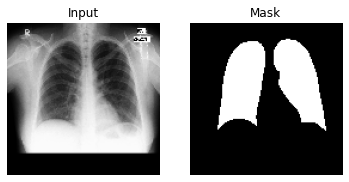

In [344]:
f, axs = plt.subplots(1, 2)
axs[0].axis('off')
axs[0].set_title("Input")
axs[0].imshow(x[0].numpy(), cmap="gray")

axs[1].axis('off')
axs[1].set_title("Mask")
axs[1].imshow(y[0].numpy(), cmap="gray")

## Creare model de tip U-Net

In [345]:
# In timpul antrenarii nu avem nevoie de functie de activare la final deoarece CrossEntropyLoss include functia Softmax
network = UNet(n_channels=1, n_classes=2)
print(network)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

Se creaza generatoarele pentru antrenare si validare pornind de la DataFrame-ul creat anterior. Se filtreaza dupa coloana `subset`.

In [346]:
train_df = dataset_df.loc[dataset_df["subset"] == "train", :]
train_ds = LungSegDataset(train_df, img_size=config["data"]["img_size"])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config['train']['bs'], shuffle=True)

valid_df = dataset_df.loc[dataset_df["subset"] == "valid", :]
valid_ds = LungSegDataset(valid_df, img_size=config["data"]["img_size"])
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=config['train']['bs'], shuffle=False)

print(f"# Train: {len(train_ds)} # Valid: {len(valid_ds)}")

# Train: 110 # Valid: 13


## Antrenare model de segmentare

In [347]:
def train(network, train_loader, valid_loader, criterion, opt, epochs, thresh=0.5):
    total_loss = {'train': [], 'valid': []}
    total_acc = {'train': [], 'valid': []}

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Starting training on device {device} ...")

    loaders = {
        'train': train_loader,
        'valid': valid_loader
    }
    metric = torchmetrics.Accuracy()
    
    network.to(device)
    criterion.to(device)

    for ep in range(epochs):
        print(f"[INFO] Epoch {ep}/{epochs - 1}")
        print("-" * 20)        
        for phase in ['train', 'valid']:
            running_loss = 0.0

            if phase == 'train':
                network.train()  # Set model to training mode
            else:
                network.eval()   # Set model to evaluate mode

            with tqdm(desc=phase, unit=' batch', total=len(loaders[phase].dataset)) as pbar:
                for data in loaders[phase]:
                    ins, tgs = data
                    ins = ins.to(device)
                    tgs = tgs.to(device)
                    
                    # seteaza toti gradientii la zero, deoarece PyTorch acumuleaza valorile lor dupa mai multe backward passes
                    opt.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        # se face forward propagation -> se calculeaza predictia
                        output = network(ins)

                        # se calculeaza eroarea/loss-ul
                        loss = criterion(output, tgs.squeeze())
                        
                        # deoarece reteaua nu include un strat de softmax, predictia finala trebuie calculata manual
                        current_predict = (F.softmax(output, dim=1)[:, 1] > thresh).float()

                        if 'cuda' in device.type:
                            current_predict = current_predict.cpu()
                            current_target = tgs.cpu().type(torch.int).squeeze()
                        else:
                            current_predict = current_predict
                            current_target = tgs.type(torch.int).squeeze()

                        # print(current_predict.shape, current_target.shape)
                        # print(current_predict.dtype, current_target.dtype)
                        acc = metric(current_predict, current_target)
                        # print(f"\tAcc on batch {i}: {acc}")

                        if phase == 'train':
                            # se face backpropagation -> se calculeaza gradientii
                            loss.backward()
                            # se actualizează weights-urile
                            opt.step()
                    
                    running_loss += loss.item() * ins.size(0)
                    # print(running_loss, loss.item())

                    if phase == 'valid':
                        # salvam ponderile modelului dupa fiecare epoca
                        torch.save(network, 'my_model.pth')
                    
                    pbar.update(ins.shape[0])


                # Calculam loss-ul pt toate batch-urile dintr-o epoca
                total_loss[phase].append(running_loss/len(loaders[phase].dataset))
                
                # Calculam acuratetea pt toate batch-urile dintr-o epoca
                acc = metric.compute()
                total_acc[phase].append(acc)

                postfix = f'error {total_loss[phase][-1]:.4f} accuracy {acc*100:.2f}%'
                pbar.set_postfix_str(postfix)

                # Resetam pt a acumula valorile dintr-o noua epoca
                metric.reset()
    
    return {'loss': total_loss, 'acc': total_acc}

In [348]:
criterion = torch.nn.CrossEntropyLoss()

if config['train']['opt'] == 'Adam':
    opt = torch.optim.Adam(network.parameters(), lr=config['train']['lr'])
elif config['train']['opt'] == 'SGD':
    opt = torch.optim.SGD(network.parameters(), lr=config['train']['lr'])

history = train(network, train_loader, valid_loader, criterion, opt, epochs=config['train']['epochs'], thresh=config['test']['threshold'])

[INFO] Starting training on device cuda:0 ...
[INFO] Epoch 0/9
--------------------


valid: 100%|██████████| 13/13 [00:03<00:00,  3.48 batch/s, error 0.5341 accuracy 75.54%]


[INFO] Epoch 1/9
--------------------


valid: 100%|██████████| 13/13 [00:06<00:00,  1.88 batch/s, error 0.2270 accuracy 95.88%]


[INFO] Epoch 2/9
--------------------


valid: 100%|██████████| 13/13 [00:03<00:00,  3.58 batch/s, error 0.1210 accuracy 97.74%]


[INFO] Epoch 3/9
--------------------


valid: 100%|██████████| 13/13 [00:03<00:00,  3.59 batch/s, error 0.1017 accuracy 98.15%]


[INFO] Epoch 4/9
--------------------


valid: 100%|██████████| 13/13 [00:03<00:00,  3.44 batch/s, error 0.0925 accuracy 98.11%]


[INFO] Epoch 5/9
--------------------


valid: 100%|██████████| 13/13 [00:03<00:00,  3.47 batch/s, error 0.0875 accuracy 97.96%]


[INFO] Epoch 6/9
--------------------


valid: 100%|██████████| 13/13 [00:06<00:00,  1.96 batch/s, error 0.0776 accuracy 98.31%]


[INFO] Epoch 7/9
--------------------


valid: 100%|██████████| 13/13 [00:03<00:00,  3.57 batch/s, error 0.0721 accuracy 98.45%]


[INFO] Epoch 8/9
--------------------


valid: 100%|██████████| 13/13 [00:03<00:00,  3.66 batch/s, error 0.0707 accuracy 98.44%]


[INFO] Epoch 9/9
--------------------


valid: 100%|██████████| 13/13 [00:03<00:00,  3.63 batch/s, error 0.0667 accuracy 98.46%]


## Afisare curbe de invatare

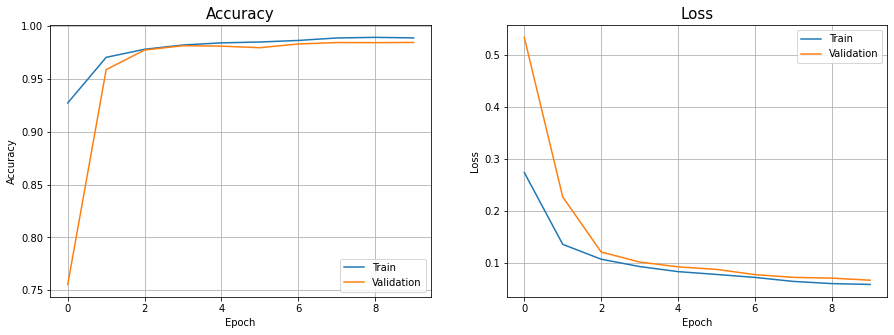

In [349]:
def plot_acc_loss(result):
    acc = result['acc']['train']
    loss = result['loss']['train']
    val_acc = result['acc']['valid']
    val_loss = result['loss']['valid']
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title('Accuracy', size=15)
    plt.legend()
    plt.grid(True)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.subplot(122)
    plt.plot(loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title('Loss', size=15)
    plt.legend()
    plt.grid(True)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.show()
    
plot_acc_loss(history)

## Testarea modelului antrenat

In acelasi mod ca si la antrenare se creaza un generator pentru subsetul cu imagini de testare. De data asta `shuffle=False`

In [350]:
def test(network, test_loader, thresh=0.5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Starting testing on device {device} ...")

    metric = torchmetrics.Accuracy()

    network.eval()
    with tqdm(desc='test', unit=' batch', total=len(test_loader.dataset)) as pbar:
        for data in test_loader:
            ins, tgs = data
            ins = ins.to(device)
            tgs = tgs.to('cpu')

            output = network(ins)
            current_predict = (F.softmax(output, dim=1)[:, 1] > thresh).float()

            if 'cuda' in device.type:
                current_predict = current_predict.cpu()
                
            acc = metric(current_predict, tgs.squeeze())
            pbar.update(ins.shape[0])
        
        acc = metric.compute()
        print(f'[INFO] Test accuracy is {acc*100:.2f} %')

In [351]:
test_df = dataset_df.loc[dataset_df["subset"] == "test", :]
test_ds = LungSegDataset(test_df, img_size=config["data"]["img_size"])
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=config["train"]["bs"], shuffle=False)

print(f"# Test: {len(test_ds)}")

del network # avoid CUDA OUT OF MEMORY ERROR
network = torch.load('my_model.pth')
test(network, test_loader, thresh=config['test']['threshold'])

# Test: 15
[INFO] Starting testing on device cuda:0 ...


test: 100%|██████████| 15/15 [00:05<00:00,  2.82 batch/s]

[INFO] Test accuracy is 98.83 %


### Vizualizare predictii

In [352]:
x, y = next(iter(test_loader))
network.eval()
y_pred = network(x.to(device='cuda'))
y_pred.shape

torch.Size([8, 2, 128, 128])

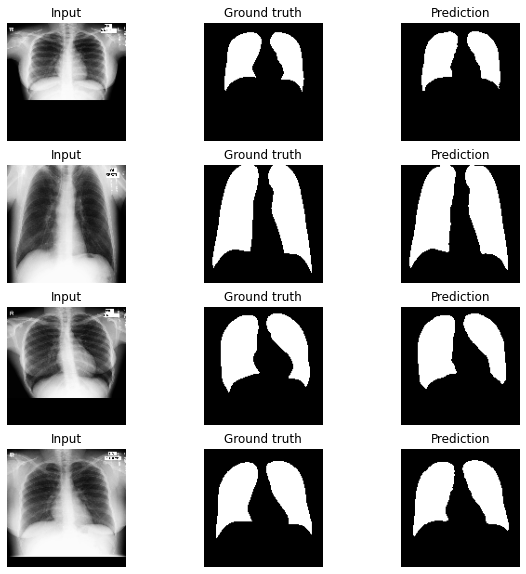

In [353]:
nr_exs = 4 # nr de exemple de afisat
fig, axs = plt.subplots(nr_exs, 3, figsize=(10, 10))
for i, (img, gt, pred) in enumerate(zip(x[:nr_exs], y[:nr_exs], y_pred[:nr_exs])):
    axs[i][0].axis('off')
    axs[i][0].set_title('Input')
    axs[i][0].imshow(img[0], cmap='gray')

    axs[i][1].axis('off')
    axs[i][1].set_title('Ground truth')
    axs[i][1].imshow(gt[0], cmap='gray')

    # print(pred.shape)
    pred = F.softmax(pred, dim=0)[1].detach().cpu().numpy()
    # print(pred.shape, pred.min(), pred.max())
    pred[pred > config['test']['threshold']] = 1
    pred[pred <= config['test']['threshold']] = 0
    pred = pred.astype(np.uint8)

    axs[i][2].axis('off')
    axs[i][2].set_title('Prediction')
    axs[i][2].imshow(pred, cmap='gray')